## 示例代码  
输出`hello world!`。  

In [37]:
from llvmlite import ir  

# 创建模块，模块名可以为空  
module = ir.Module(name="main")  

# 创建int32 类型  
i32 = ir.IntType(32)  
# 创建int8 * 指针类型  
voidptr_ty = ir.IntType(8).as_pointer()  


# 创建函数类型 int func(void * ...)，支持可变长参数  
printf_ty = ir.FunctionType(ir.IntType(32), [voidptr_ty], var_arg=True)  
# 声明int printf(void * ...)
printf = ir.Function(module, printf_ty, name="printf")

# If you need to be compatible with emoji, Chinese and other utf8 characters, you need to modify fmt.
# fmt = bytearray("🦒, %s! %i times!\n\0".encode('utf-8'))
# # c_fmt = ir.Constant(ir.ArrayType(ir.IntType(8), len(fmt)), fmt)
# fmt = "hello %s!\n\0"
# c_fmt = ir.Constant(ir.ArrayType(ir.IntType(8), len(fmt)), bytearray(fmt.encode("utf8")))
fmt = bytearray("🦒 hello %s! \n\0".encode('utf-8'))
c_fmt = ir.Constant(ir.ArrayType(ir.IntType(8), len(fmt)),fmt)
global_fmt = ir.GlobalVariable(module, c_fmt.type, name="fstr")
global_fmt.linkage = 'internal'
global_fmt.global_constant = True
global_fmt.initializer = c_fmt


# 创建函数类型int func()，无参数  
fn_ty = ir.FunctionType(i32,())  
# 创建int main() 函数
func = ir.Function(module, fn_ty, name='main')  
# 添加函数体block    
block = func.append_basic_block(name="entry")  
# 构建函数体
builder = ir.IRBuilder(block)    


arg = "world\0"  
c_arg = ir.Constant(ir.ArrayType(ir.IntType(8), len(arg)), bytearray(arg.encode("utf8")))
c_str = builder.alloca(c_arg.type)
builder.store(c_arg, c_str)

# 指针类型转换
fmt_arg = builder.bitcast(global_fmt, voidptr_ty)
builder.call(printf, [fmt_arg, c_str])

# 创建返回值
res = i32(0)  
# 添加返回值
builder.ret(res)  

    

<ir.Ret '.6' of type 'void', opname 'ret', operands [<ir.Constant type='i32' value=0>]>

## 保存IR   

In [38]:

with open('./a.out.ll', 'w') as f:
    f.write(str(module))

## 编译   
因为llvmlite 暂时还没有集成`lld` 工具，所以只能通过系统命令将生成的`.ll` 源码或者`.obj` 文件编译成可执行程序。看Github 上的[PR 898](https://github.com/numba/llvmlite/pull/898) 应该在`v4.0` 正式版就将集成`lld` 工具。  

In [39]:
import subprocess

p = subprocess.Popen("clang ./a.out.ll", shell=True, stdout=subprocess.PIPE)
r = p.stdout.read()
print(r)

b''


## 测试  
有以下三个命令来查看程序退出时的代码，`ipynb` 默认用的是`cmd`。  
- `*nix`：`echo $?`  
- `powershell`：`echo $LASTEXITCODE`  
- `cmd`：`echo %errorlevel%`

In [40]:
!a.exe
!echo %errorlevel%

🦒 hello world! 
0


## Clang 编译C 到 IR

In [41]:
!clang -emit-llvm -Wimplicit-function-declaration -S -c main.c -o main.ll

## 打印  

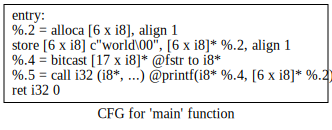

In [44]:
from llvmlite import binding  
dot = binding.get_function_cfg(func)  
binding.view_dot_graph(dot)